### Segmentation with RANSAC

In [1]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import time

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


#### Load data 

In [2]:
pcd = o3d.io.read_point_cloud("../data/interim/wkd-house_1_8xds.ply")

In [3]:
# visualisasi data
def visualisasi_data(pcd):
    o3d.visualization.draw_geometries([pcd])
    

In [4]:
#Down samsampling
pcd_down = pcd.voxel_down_sample(0.05)
print(pcd)
print(pcd_down)

PointCloud with 70775329 points.
PointCloud with 524347 points.


In [5]:
# visualisasi_data(pcd_down)

In [6]:
# Normalisasi
pcd_down.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(
        radius=0.1,
        max_nn=30
    )
)

print(pcd_down)

PointCloud with 524347 points.


In [7]:
# visualisasi_data(pcd_down)

In [8]:
# Plane Sementation dengan ransac
plane_model, inliers = pcd_down.segment_plane(
    distance_threshold=0.02,
    ransac_n=4,
    num_iterations=150000
)


In [9]:
# visualisasi akhir
inlier_cloud = pcd_down.select_by_index(inliers)
outlier_cloud = pcd_down.select_by_index(inliers, invert=True)

inlier_cloud.paint_uniform_color([1, 0, 0])
outlier_cloud.paint_uniform_color([0.5, 0.5, 0.5])

# o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])


PointCloud with 488088 points.

In [10]:
# Noise Removal
pcd_down, ind = pcd_down.remove_statistical_outlier(
    nb_neighbors=50,
    std_ratio=2.0
)

# o3d.visualization.draw_geometries([pcd_down])


In [11]:
# remove radius
pcd, ind = pcd_down.remove_radius_outlier(
    nb_points=1000,
    radius=0.3
)

# o3d.visualization.draw_geometries([pcd_down])


In [12]:
# labels = np.array(
#     pcd_down.cluster_dbscan(eps=0.2, min_points=50)
# )

# # hanya ambil cluster besar
# main_cluster = np.argmax(np.bincount(labels[labels >= 0]))
# idx = np.where(labels == main_cluster)[0]
# pcd_down = pcd_down.select_by_index(idx)


In [13]:
# o3d.visualization.draw_geometries([pcd_down])

In [14]:
# # Multiplane Segmentations
# planes = []
# rest = pcd_down

# start = time.time()
# for i in range(5):
#     plane_model, inliers = rest.segment_plane(
#         distance_threshold=0.02,
#         ransac_n=4,
#         num_iterations=100000
#     )
    
#     plane = rest.select_by_index(inliers)
#     rest = rest.select_by_index(inliers, invert=True)

#     planes.append(plane)

# print(time.time() - start)

In [15]:
# # visualisasi akhir
# inlier_cloud = pcd_down.select_by_index(inliers)
# outlier_cloud = pcd_down.select_by_index(inliers, invert=True)

# inlier_cloud.paint_uniform_color([1, 0, 0])
# outlier_cloud.paint_uniform_color([0.5, 0.5, 0.5])

# o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])


In [16]:
# Clustering DB SCANN

# labels = np.array(
#     pcd_down.cluster_dbscan(
#         eps=0.1,
#         min_points=50
#     )
# )

# print("Jumlah cluster:", labels.max() + 1)


In [17]:
# VISUALISASI CLUSTER

# colors = plt.get_cmap("tab20")(labels / (labels.max() + 1))
# colors[labels < 0] = 0
# pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])

# o3d.visualization.draw_geometries([pcd_down])


### 

In [18]:
points  = np.asarray(pcd_down.points)
z_values = points[:, 2]

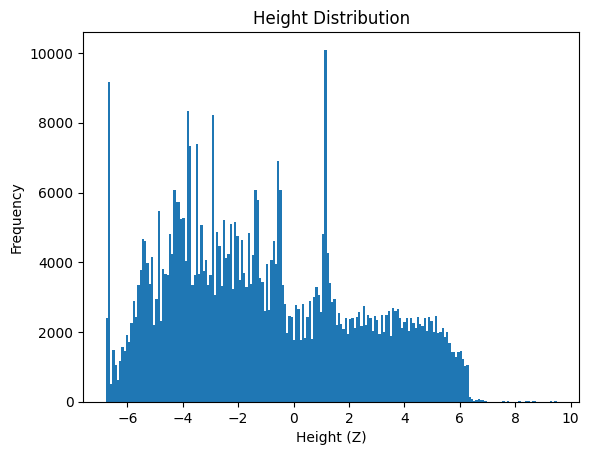

In [19]:
plt.hist(z_values, bins=200)
plt.xlabel("Height (Z)")
plt.ylabel("Frequency")
plt.title("Height Distribution")
plt.show()

In [26]:
#  Deteksi Threshold Atap


z_threshold = np.percentile(z_values, 70)

roof_idx = np.where(z_values > z_threshold)[0]
non_roof_idx = np.where(z_values <= z_threshold)[0]

roof = pcd_down.select_by_index(roof_idx)
building = pcd_down.select_by_index(non_roof_idx)

In [21]:
# Visualisasi
roof.paint_uniform_color([1, 0, 0])
building.paint_uniform_color([0, 1, 0])

o3d.visualization.draw_geometries([roof, building])

In [22]:
# dbscarn
labels = np.array(
    building.cluster_dbscan(
        eps=0.2,
        min_points=30
    )
)


In [23]:
cluster_sizes = [(labels == i).sum() for i in range(labels.max() + 1)]
main_cluster = np.argmax(cluster_sizes)

idx = np.where(labels == main_cluster)[0]
building_clean = building.select_by_index(idx)


In [24]:
pcd_clean = building_clean + roof

In [27]:
visualisasi_data(pcd_clean)